In [6]:
import numpy as np
import matplotlib.pyplot as pl
from math import pi
from sympy import sqrt

In [7]:
class Potential:
        def __init__(self, name, parms, v, ft):
                self.name = name
                self.parms = parms
                self.v = v
                self.ft = ft
        def __str__(self):
                return self.name

class PotentialFactory:
        def __init__(self):
                self.potentialList = {}

        def addType(self, name, v, ft):
                potential = { "V" : v, "FourierTransform" : ft }
                self.potentialList[name] = potential
       
        def createPotential(self, name, parms):
                return Potential(name, parms,self.potentialList[name]["V"](parms),
                                 self.potentialList[name]["FourierTransform"](parms) )

# instantiate factory
pf = PotentialFactory()
#
# SECH = 1/COSH
#
def sechpotGenerator(parms):
        a = parms["lattice"]
        a0 = parms["width"]
        v0 = parms["depth"] 
        def pot(N, m):
                x = np.linspace(-N*a,N*a,N*m) #m defining our descritization
                U = np.zeros(len(x))
                #define grid
                for n in range(-N,N+1):
                        U = U - 1/np.cosh((x-n*a)/a0) #potential v(x)
                return x,v0*U
        return pot 


def sechFTGenerator(parms):
        a = parms["lattice"]
        a0 = parms["width"]
        v0 = parms["depth"] 
        def ft(m):
                Ug=-1/np.cosh(pi**2*a0*m/a)
                return Ug*v0*pi*a0/a
        return ft #returns Fourier Transform

    
pf.addType("sech", sechpotGenerator, sechFTGenerator) #performing transform
#
# SAWTOOTH (not working) - due to discontinuity



def sawpotGenerator(parms):
        a = parms["lattice"]
        v0 = parms["depth"]
        def pot(N, m):
                x = np.linspace(-N*a,N*a,2*N*m) 
                U = np.zeros(len(x))
                #define grid
                for n in range(-N,N+1):
                    l=(N+n)*m
                    u= l+m-1
                    U[l:u] = x[l:u]/a - n  
                return x,-v0*U
        return pot 

def sawFTGenerator(parms):
        a = parms["lattice"]
        v0 = parms["depth"]
        def ft(m):
            if m==0:
                Ug = pi*a/2
            else:
                Ug = -2j/m    
            return -Ug*v0/pi/a
        return ft

    
pf.addType("saw", sawpotGenerator, sawFTGenerator)
#
# COS
#
def cospotGenerator(parms):
        a = parms["lattice"]
        v0 = parms["depth"]
        def pot(N, m):
            x = np.linspace(-N*a,N*a,N*m)
            return x,v0*(np.cos(2*pi*x/a)-1)
        return pot

def cosFTGenerator(parms):
        a = parms["lattice"]
        v0 = parms["depth"]
        def ft(m):
            Ug = 0
            
            if abs(m) == 1:
                Ug = v0/2
            elif m == 0:
                Ug = -v0
            return Ug  
        return ft
    
pf.addType("cos", cospotGenerator, cosFTGenerator)
#
# WELL (not working)

def wellpotGenerator(parms):
        a = parms["lattice"]
        h = parms["width"]
        v0 = parms["depth"]
        def pot(N, m):
            x = np.linspace(-N*a,N*a,2*N*m)
            U = np.zeros(len(x))
            for n in range(-N,N):
                l=(N+n)*m
                u= l+m-1
                for ix in range(l,u):
                    y = x[ix]-n*a
                    if y>0 and y<= a/h: 
                        U[ix] = v0
            return x,-v0*U
        return pot
    
    
    
def wellFTGenerator(parms):
        a = parms["lattice"]
        h = parms["width"]
        v0 = parms["depth"]
        def ft(m):
            if m==0:
                Ug = -pi*a/h
            else:
                Ug = -1j/m*(1-(np.exp(2j*pi*a/h))**m)  
            return Ug*v0/pi/2
        return ft

pf.addType("well", wellpotGenerator, wellFTGenerator)

In [19]:
def Gvec(m,a):
        return 2*pi*m/a

def kvec(i,a,N):
        return -pi/a + i*2*pi/a/(N-1)

def kinetic(i,m,a,N):
        return 0.5*(kvec(i,a,N) - Gvec(m,a))**2 

    
def fillmatrix(ik,N_G,N_k,potential): #matrix we want to fill with Hamiltonian
        a = potential.parms["lattice"]
        M = np.zeros((2*N_G+1,2*N_G+1),dtype=np.complex_) #matrix to fill
        for ig1 in range(-N_G,N_G+1):
                for ig2 in range(-N_G,N_G+1):
                        if (ig1==ig2):
                                M[ig1+N_G,ig2+N_G] = kinetic(ik,ig1,a,N_k)
                                #kinetic - Diagonal
                        else:
                                M[ig1+N_G,ig2+N_G] = potential.ft(ig2-ig1)
                                #potential - Outside
        return M
#No potential component for KE




def solveSchroedinger(N_G,N_k,N_b,potential):#iterates k-point by k-point
    #e and c are NOT dependent on ik, however, we alter to make e,c k-dependent
    ek = np.zeros((N_k,N_b)) #energy band
    ck = np.zeros((2*N_G+1,N_k,N_b),dtype=np.complex_)#eigenstate, is a vector with dimension
    for ik in range(N_k): 
        M=fillmatrix(ik,N_G,N_k,potential)
        [e,c]=np.linalg.eigh(M) #because orthogonal basis standard eigenvalue problem
        
        ek[ik,0:N_b] = e[0:N_b]
        ck[:,ik,0:N_b] = c[:,0:N_b]
        
    return ek,ck


def solveSchroedinger1(N_G,N_k,N_b,potential):#iterates k-point by k-point
    #e and c are NOT dependent on ik, however, we alter to make e,c k-dependent
    
    ek = np.zeros((N_k,N_b)) #energy band
    ck = np.zeros((2*N_G+1,N_k,N_b),dtype=np.complex_)#eigenstate, is a vector with dimension
    for ik in range(N_k): 
        M=fillmatrix(ik,N_G,N_k,potential)
        [e,c]=np.linalg.eigh(M) #because orthogonal basis standard eigenvalue problem
        
        ek[ik,0:N_b] = e[0:N_b]
        ck[:,ik,0:N_b] = c[:,0:N_b]
        return ck


    
def OptimalBasis(sb, N_b, N_k, ck): 
    
    OB_bi = np.zeros((np.shape(ck)[0], np.shape(ck)[1] * np.shape(ck)[2]), dtype= np.complex_)
    ckTilda = np.zeros(np.shape(ck), dtype= np.complex_)
    
    N = N_b 
    for i in range(N_b): 
        OB_bi[:, i] = ck[:, 0, i] 
     
    for l in range(1, N_k):
        for i in range(N_b):
            ckTilda[:, l, i] = ck[:, l , i]
            for j in range(N):
                ckTilda[:, l , i] -= OB_bi[:,j]*(np.dot(OB_bi[:,j], ck[:, l , i]))        
        Np = N
        for i in range(N_b):
            for j in range(Np, N):
                ckTilda[:, l, i] -= OB_bi[i, j]*(np.dot(OB_bi[:,j], ck[:, l , i]))
                alpha = np.dot(ckTilda[:, l, i], ckTilda[:, l ,i])
                if alpha >= sb:
                    N += 1
                    OB_bi[:,N] = ckTilda[:,l,i] / sqrt(alpha)
    
    print(N_b*N_k, N)
    bi_out = np.zeros((np.shape(ck)[0], N))
    bi_out[:, :] = OB_bi[:, 0:N]
    return bi_out

    
def OptimalBasisNEW(sb, N_b, N_k, OBck, N_G, potential): 
    OBck = solveSchroedinger1(N_G,N_k,N_b,potential)
    OB_bi = np.zeros((np.shape(OBck)[0], np.shape(OBck)[1] * np.shape(OBck)[2]), dtype= np.complex_)
    ckTilda = np.zeros(np.shape(OBck), dtype= np.complex_)
    
    N = N_b 
    for i in range(N_b): 
        OBck[:, 0, i]  = OB_bi[:, i]
        #OB_bi[:, i] = OBck[:, 0, i] 
     
    for l in range(1, N_k):
        for i in range(N_b):
            ckTilda[:, l, i] = OBck[:, l , i]
            for j in range(N):
                ckTilda[:, l , i] -= OB_bi[:,j]*(np.dot(OB_bi[:,j], OBck[:, l , i]))        
        Np = N
        for i in range(N_b):
            for j in range(Np, N):
                ckTilda[:, l, i] -= OB_bi[i, j]*(np.dot(OB_bi[:,j], OBck[:, l , i]))
                alpha = np.dot(ckTilda[:, l, i], ckTilda[:, l ,i])
                if alpha >= sb:
                    N += 1
                    OB_bi[:,N] = ckTilda[:,l,i] / sqrt(alpha)
    
    #print(N_b*N_k, N)
    bi_out = np.zeros((np.shape(OBck)[0], N))
    bi_out[:, :] = OB_bi[:, 0:N]
    return bi_out
   
    
def determineBasis(N_G, N_b, N_k, sb, ck, potential):
    [ek,ck] = solveSchroedinger(N_G,N_k,N_b,potential)
    for i in range(N_b):
        basis = ck
        return basis
        
def determineOptimalBasis(N_G, N_b, N_k, sb, ck, potential):
    [ek,ck] = solveSchroedinger(N_G,N_k,N_b,potential)
    ckNEW = OptimalBasis(sb, N_b, N_k, ck)
    for i in range(N_b):
        optimalBasis = ckNEW
        return optimalBasis
        
            
#defining optimal product basis required for linear repsonse calculations 
def optimalProductBasis(sp, N_b, N_k, bi_out):
    
    BjTilda = np.zeros(np.shape(bi_out)[0], np.shape(bi_out)[1] * np.shape(bi_out)[2], dtype = np.complex_)
    BjTildaPrime = np.zeros(np.shape(bi_out), dtype=np.complex_)
    
    Np = 0
    for i in range(1, N_b):
        for j in range(1, N_b):
            bi_out_product = bi_out[:, i]*bi_out[:, j]
            BjTilda[:, i, j] = bi_out_product
            
        for j in range(1, N_b):
            for alpha in range(Np):
                BjTildaPrime[:, i, j] -= BjTida[:,alpha]*(np.dot(BjTilda[:, alpha], bi_out_product[:, j]))
                   
        NpPrime = 0
        for j in range(1, N_b):
            for alpha in range(Np + 1, Np + NpPrime):
                BjTildaPrimePrime[:, j, alpha] -= BjTilda[:, alpha]*(np.dot(BjTilda[:, alpha], BjTildaPrime[:, j]))
                                                                                                      
            beta = np.dot(BjTildaPrimePrime[:, i, j], BjTildaPrimePrime[:, i, j])                                              
            if beta >= sp:
                NpPrime = NpPrime + 1
                BNpPrime = BjTildaPrimePrime / sqrt(beta)
          
        Np = Np + NpPrime 
    bi_final = np.zeros((np.shape(bi_out_product)[0], N))
    bi_final[:, :] = BNpPrime[:, 0:N]
    return bi_final
    
                                                
def NewSolveSchrodinger(Sb,ck,N_G,N_k,N_b,potential):
    ek = np.zeros((N_k,N_b))#energy band
    ck = np.zeros((2*N_G+1,N_k,N_b),dtype=np.complex_)
    for ik in range(N_k): 
        M=fillmatrix(ik,N_G,N_k,potential)
        [e,c]=np.linalg.eigh(M) #because orthogonal basis standard eigenvalue problem
        
        ek[ik,0:N_b] = e[0:N_b]
        ck[:,ik,0:N_b] = c[:,0:N_b]
        ckNEW = OptimalBasis(Sb, N_k, N_b, ck)
        return ek, ckNEW


#------END CONSTRUCTION--------------------------------------------------------

def plotBand(ek,potential,symbol):
    a = potential.parms["lattice"]
    [Nk,Nb] = np.shape(ek)
    k = np.zeros(Nk)
    
    for ik in range(Nk):
        k[ik]=kvec(ik,a,Nk)
        
    for ib in range(Nb):
        pl.plot(k,ek[:,ib],symbol)
        
    pl.show()
    return 


def OBplotBand(ek,potential,symbol):
    a = potential.parms["lattice"]
    [Nk,Nb] = np.shape(ek)
    k = np.zeros(Nk)
    
    for ik in range(Nk):
        k[ik]=kvec(ik,a,Nk)
        
    for ib in range(Nb):
        pl.plot(k,ek[:,ib],symbol)
        
    pl.show()
    return 


def plotFun(ik,ek,ck,Ncell,Npoints,potential,symbol,shift):
    a = potential.parms["lattice"]
    [NG,Nk,Nb] = np.shape(ck)
    N = int(NG/2-1) #check dimension ck
    x, U = potential.v(Ncell, Npoints)
    pl.plot(x,U)
    
    for ib in range(Nb):
        phi = np.full(len(x),shift*ek[ik,ib]) #shift - bloch?
        #shift allows to adjust to improve visualisation
        
        for ig in range(NG):
            phi = phi + ck[ig,ik,ib]*np.exp(1j*(kvec(ik,a,Nk)-Gvec(ig-N,a))*x)
        pl.plot(x,phi,symbol)
    pl.show()
    return

def OBplotFun(N_G,N_k,N_b,sb, ik,ek,ck,Ncell,Npoints,potential,symbol,shift):
    [ek,ck] = solveSchroedinger(N_G,N_k,N_b,potential)
    ckNEW = OptimalBasis(sb, N_b, N_k, ck)
    
    a = potential.parms["lattice"]
    [NG,Nk,Nb] = np.shape(ck)
    N = int(NG/2-1) #check dimension ck
    x, U = potential.v(Ncell, Npoints)
    pl.plot(x,U)
    
    for ib in range(Nb):
        phi = np.full(len(x),shift*ek[ik,ib]) #shift - bloch?
        #shift allows to adjust to improve visualisation
        
        for ig in range(NG):
            phi = phi + ck[ig,ik,ib]*np.exp(1j*(kvec(ik,a,Nk)-Gvec(ig-N,a))*x)
        pl.plot(x,phi,symbol)
    pl.show()
    return





In [15]:
def main():
    ptparms = { "lattice" : 2, "depth" : 0.1, "width" :0.1 }
    ptl = pf.createPotential("sech", ptparms)
    
    
    print("Enter parameter sb to test:")
    sb = input()
    print("Enter number of bands:")
    N_b = input()
    print("Enter number of k points:")
    N_k = input()
    print("Enter N_G:")
    N_G = input()

    
    ckNEW = len(solveSchroedinger1(int(N_G), int(N_k), int(N_b), ptl))
    print(ckNEW)
    OB = len(OptimalBasisNEW(sb, int(N_b), int(N_k), ckNEW, int(N_G,), ptl))
    
    print("Standard Basis = " + str(ckNEW), ",", "Optimal Basis = " + str(OB))
    print("N_b * N_k = ", int(N_b)*int(N_k))
    
    #[ekOB,ckOB] = NewSolveSchrodinger(sb,ckNEW, int(N_G), int(N_k), int(N_b), ptl)
    #length = len(ckOB)
    #print(length)
    
    
if __name__ == "__main__":
    main()

Enter parameter sb to test:
Enter number of bands:
Enter number of k points:
Enter N_G:
7
Standard Basis = 7 , Optimal Basis = 7
N_b * N_k =  150


C:\Users\charl\AppData\Local\Temp/ipykernel_1508/3660443000.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  bi_out[:, :] = OB_bi[:, 0:N]


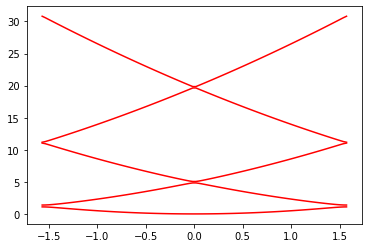

C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to rea

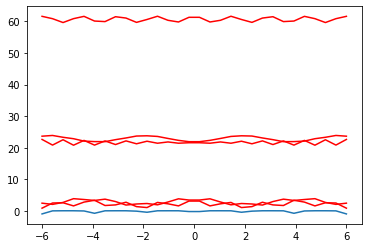

In [23]:


ptparms = { "lattice" : 2, "depth" : 1, "width" :0.1 }
ptl = pf.createPotential("sech", ptparms)
[ek,ck] = solveSchroedinger(10,100,5,ptl)
plotBand(ek,ptl,'r-')
plotFun(2,ek,ck,3,10,ptl,'r-',2)


ptparms = { "lattice" : 2, "depth" : 1, "width" :0.1 }
ptnew = pf.createPotential("sech", ptparms)
[ek,bi_out] = solveSchroedinger(10,100,5,ptnew)


In [13]:
ptparms = { "lattice" : 2, "depth" : 1, "width" :0.1 }
ptl = pf.createPotential("sech", ptparms)
[ek,ck] = solveSchroedinger(10,100,5,ptl)
print(OptimalBasisNEW(5, 3, 100, ck, 10, ptl))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


C:\Users\charl\AppData\Local\Temp/ipykernel_1508/3109629624.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  bi_out[:, :] = OB_bi[:, 0:N]


300 3
[[ 9.30450641e-11 -9.18768034e-11 -1.14697255e-08]
 [ 2.04734809e-08 -2.02217939e-08 -2.69884897e-06]
 [ 5.14572908e-06 -5.08560600e-06 -8.09317653e-04]
 [ 1.62657616e-03 -1.61070300e-03 -7.07104450e-01]
 [ 7.07104910e-01 -7.07104947e-01  1.62658099e-03]
 [ 7.07104910e-01  7.07104947e-01  1.62658097e-03]
 [ 1.62657616e-03  1.61070300e-03 -7.07104445e-01]
 [ 5.14572908e-06  5.08560600e-06 -8.09317648e-04]
 [ 2.04734810e-08  2.02217939e-08 -2.69884896e-06]
 [ 9.30452021e-11  9.18768537e-11 -1.14697394e-08]
 [ 4.60345590e-13  4.54502183e-13 -5.49041534e-11]]
33


C:\Users\charl\AppData\Local\Temp/ipykernel_1508/1645452086.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  bi_out[:, :] = OB_bi[:, 0:N]
C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\charl\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return 

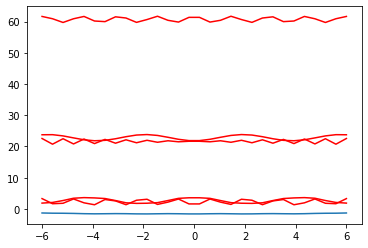

In [38]:
ptparms = { "lattice" : 2, "depth" : 1, "width" :1 }
ptl = pf.createPotential("sech", ptparms)
[ek,ck] = solveSchroedinger(10,100,5,ptl)

#test = determineBasis(5, 3, 100, 0.001, ck, ptl)
#print(test)
#print(test.size)

test2 = determineOptimalBasis(5, 3, 100, 0.1, ck, ptl)
print(test2)
print(test2.size)

#OBplotFun(2,100,3,10,2,ek,test2,3,10,ptl, 'b-',2)
plotFun(2,ek,ck,3,10,ptl,'r-',2)
